In [1]:
!pip install segmentation-models-pytorch
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 7.5 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 61.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=293d625d1cba760b453b2c2fb294e64382b47f54643afa056f4169f72e6dcc6a
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=ec6563a3c3787a50d0275fce24b022da0ec8a7a2205ecc26e0617411ed9d3252
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
from google.colab import drive


In [3]:

import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/mckinsey_musketeers/Data/ai_ready/x-ai_data.csv")
df

,filename,class,split
0,silos_256-0-0--6-15--152-30320.png,0,validation
1,silos_256-0-0--6-15--1195-31353.png,0,train
2,silos_256-0-0--6-15-283-30628.png,0,train
3,silos_256-0-0--6-15--339-30012.png,0,validation
4,silos_256-0-0--6-15--404-30011.png,0,train
...,...,...,...
1994,silos_256-0-0--6-16--482-29384.png,1,train
1995,silos_256-0-0--6-16--1332-28589.png,1,validation
1996,silos_256-0-0--6-16--1142-28595.png,1,train
1997,silos_256-0-0--6-15--328-29482.png,1,train


In [6]:
df = df.loc[df["class"] == 1]
df.reset_index(inplace=True, drop=True)

In [7]:
df.to_csv("/content/drive/MyDrive/mckinsey_musketeers/Data/ai_ready/silo_only.csv")

Helper

In [8]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [9]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

CONFIG

In [10]:
CSV_FILE = "/content/drive/MyDrive/mckinsey_musketeers/Data/ai_ready/silo_only.csv" 
DATA_DIR = "/content/drive/MyDrive/mckinsey_musketeers/Data/ai_ready"
DEVICE = "cuda"
EPOCHS = 10
LR = 0.006
BATCH_SIZE = 16
IMG_SIZE = 256
ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [11]:
df = pd.read_csv(CSV_FILE)
df.head()

,Unnamed: 0,filename,class,split
0,0,silos_256-0-0--6-15-174-31048.png,1,train
1,1,silos_256-0-0--6-15-651-30254.png,1,train
2,2,silos_256-0-0--6-15--1137-31027.png,1,train
3,3,silos_256-0-0--6-16--936-30650.png,1,train
4,4,silos_256-0-0--6-16--1204-28815.png,1,train


In [12]:
df.loc[:, 'images'] = 'images/' + df.loc[:, 'filename']
df.loc[:, 'masks'] = 'masks/' + df.loc[:, 'filename']

df.head()

,Unnamed: 0,filename,class,split,images,masks
0,0,silos_256-0-0--6-15-174-31048.png,1,train,images/silos_256-0-0--6-15-174-31048.png,masks/silos_256-0-0--6-15-174-31048.png
1,1,silos_256-0-0--6-15-651-30254.png,1,train,images/silos_256-0-0--6-15-651-30254.png,masks/silos_256-0-0--6-15-651-30254.png
2,2,silos_256-0-0--6-15--1137-31027.png,1,train,images/silos_256-0-0--6-15--1137-31027.png,masks/silos_256-0-0--6-15--1137-31027.png
3,3,silos_256-0-0--6-16--936-30650.png,1,train,images/silos_256-0-0--6-16--936-30650.png,masks/silos_256-0-0--6-16--936-30650.png
4,4,silos_256-0-0--6-16--1204-28815.png,1,train,images/silos_256-0-0--6-16--1204-28815.png,masks/silos_256-0-0--6-16--1204-28815.png


In [13]:
idx=15
row=df.iloc[idx]
image_path = DATA_DIR + "/" + row.images
mask_path = DATA_DIR + "/" + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255



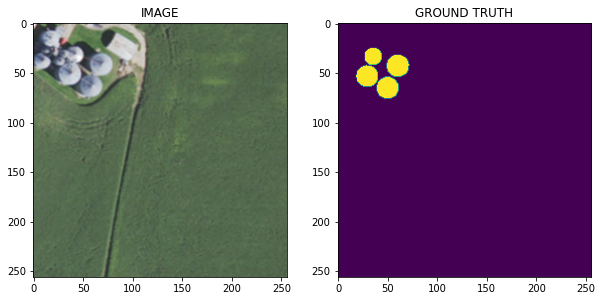

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask) #cmap = 'gray'

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

In [16]:
len(train_df)

800

## Augmentation function

In [17]:
import albumentations as A

In [18]:
# !pip install -q opencv-python==4.5.5.64
# !pip install -q --force-reinstall albumentations==1.0.3

In [19]:
def get_trains_augs():
  return A.compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ]) 

def get_valid_augs():
  return A.compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

In [20]:
# get_trains_augs()

## Create custom dataset

In [21]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Tuple


In [22]:
class SegmentationDataset(Dataset):
  def __init__(self, df):
    self.df = df
            
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + "/" + row.images
    mask_path = DATA_DIR +"/" + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255  # format is (h, w)

    mask = np.expand_dims(mask, axis=-1) #(h, w, channel)
    
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (channel, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) # (channel, h, w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)) # / 255.0

    return image, mask

In [23]:
trainset = SegmentationDataset(train_df)
validset = SegmentationDataset(valid_df)

In [24]:
print(f'Size of trainset {len(trainset)}')
print(f'Size of validset {len(validset)}')

Size of trainset 800
Size of validset 200


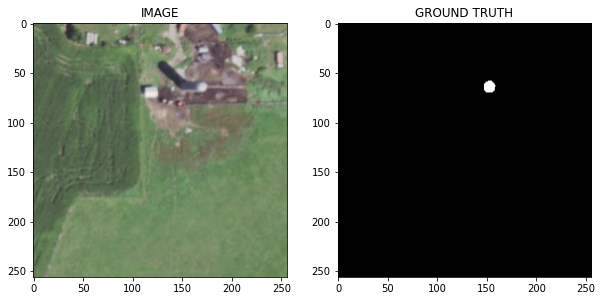

In [25]:
idx = 20

image, mask = trainset[idx]

show_image(image, mask)

In [26]:
## Load Dataset into batches

In [27]:
from torch.utils.data import DataLoader

In [28]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [29]:
print(f"Total no of batches in trainloader: {len(trainloader)}")
print(f"Total no of batches in validloader: {len(validloader)}")

Total no of batches in trainloader: 50
Total no of batches in validloader: 13


In [30]:
for images, masks in trainloader:
  print(f'One batch image shape :{images.shape}')
  print(f'One batch mask shape :{masks.shape}')
  break


One batch image shape :torch.Size([16, 3, 256, 256])
One batch mask shape :torch.Size([16, 1, 256, 256])


Create segmentation model

In [31]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [32]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None)
    
  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:

      return logits, DiceLoss(mode="binary")(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks) # We use both the Diceloss and the Binary crossentropy

    return logits # During the predictions mask is going to be None, so we only return the predictions



In [33]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


In [34]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [35]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


In [36]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs, masks=None):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)

        if masks != None:
          return outputs, DiceLoss(mode="binary")(outputs, masks) + nn.BCEWithLogitsLoss()(outputs, masks) # We use both the Diceloss and the Binary crossentropy

        return outputs

In [37]:
# own_model = build_unet()
# own_model.to(DEVICE)

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [38]:
model =SegmentationModel()

model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

## Train and validation function

In [39]:
def train_fn(dataloader, model, optimizer):

  model.train() # Turn on dropout, batchnorm etc.

  total_loss = 0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()



  return total_loss / len(dataloader)

In [40]:

def eval_fn(dataloader, model):

  model.eval() # Turn OFF dropout, batchnorm etc.

  total_loss = 0
  
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    logits, loss = model(images, masks)
    loss.backward()

    total_loss += loss.item()



  return total_loss / len(dataloader)

## Train model

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [42]:
train_loss_ls = []
val_loss_ls = []

best_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  train_loss_ls.append(train_loss)
  val_loss_ls.append(valid_loss)

  if valid_loss < best_loss :
    torch.save(model.state_dict(), "second_model.pt")
    print('SAVED_MODEL')
    best_loss = valid_loss
    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")


100%|██████████| 13/13 [04:48<00:00, 22.21s/it]


SAVED_MODEL
Epoch : 1 Train Loss : 0.7448894852399826 Valid Loss : 1.1824743793560908


100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


SAVED_MODEL
Epoch : 2 Train Loss : 0.5382859480381011 Valid Loss : 0.9092466922906729


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


SAVED_MODEL
Epoch : 3 Train Loss : 0.5341504901647568 Valid Loss : 0.530342888373595


100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


SAVED_MODEL
Epoch : 6 Train Loss : 0.44754890978336337 Valid Loss : 0.5153223803410163


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


SAVED_MODEL
Epoch : 8 Train Loss : 0.41758072078228 Valid Loss : 0.4898512546832745


100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


In [43]:

import gc

gc.collect()

torch.cuda.empty_cache()

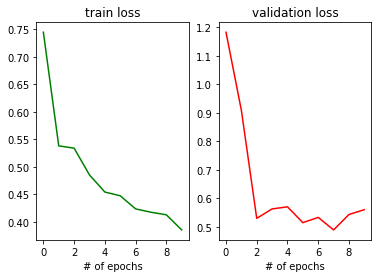

In [47]:
fig, axs = plt.subplots(1, 2)
# fig.suptitle('Vertically stacked subplots')
axs[0].plot(train_loss_ls,'g')
axs[0].set_title("train loss")
axs[1].plot(val_loss_ls, 'r')
axs[1].set_title("validation loss")
for ax in axs.flat:
    ax.set(xlabel='# of epochs')
# axs[1].title("Validation loss")


In [48]:
idx = 40


model.load_state_dict(torch.load('/content/drive/MyDrive/mckinsey_musketeers/image_segmentation/second_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h,w) --> (batch, channel, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1

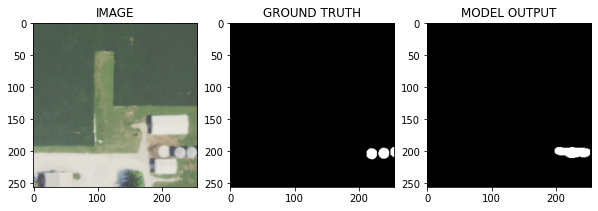

In [49]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))